# Binary Classification 
### Using the MNIST dataset (digits)

In [1]:
#import dependencies
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

## Data Exploration

In [2]:
#fetch dataset from openml
mnist = fetch_openml('mnist_784', as_frame=False) #as_frame = false gives numpy arrays and not pandas dataset, numpy arrays better for image data

/Users/Cheks/opt/anaconda3/envs/python/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


### Visualise dataset and target

In [3]:
#store the data and target attributes
X, y = mnist.data, mnist.target

#what does the input data look like?
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
#what does the target data look like?
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [5]:
X.shape #70k rows, 784 columns
#70k images, each image has 28*28 = 784 pixels (features). Each feature is a number from 0 (white) to 255 (black) which represents colour intensity.

(70000, 784)

In [6]:
#define a function to visualise an input

def show_digit(input_data):
    image = input_data.reshape(28,28)

    #use imshow to show an image based on numpy array data. binary is greyscale (black/white)
    plt.imshow(image, cmap = "binary")

    #turn off axes
    plt.axis("off")


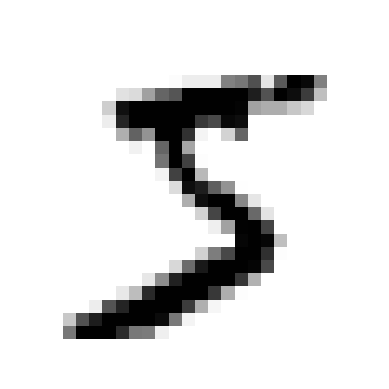

In [7]:
#visualise
some_input = X[0]
show_digit(some_input)

In [8]:
y[0] #digit is a 5

'5'

## Create a Good Test Set

The MNIST dataset returned by fetch_openml is already split into a training set of the first 60k images and a test set of the last 10k images, and is already shuffled. 

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

In this subsection we aim to train a binary classifier that tells us if a digit is 5 or not 5.

In [10]:
#create target vectors
y_train_5 = (y_train == '5') #true for all instances where the target is 5, false otherwise
y_test_5 = (y_test == '5')

In [11]:
#pick a classifier and train it - here we use SGDClassifier. define and fit.
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5) #tells classifier if 5 or not a 5

SGDClassifier(random_state=42)

In [12]:
#predict
sgd_clf.predict([some_input]) #takes in an array. should be true since it was a 5

array([ True])

## Evaluating a Binary Classifier

### Measuring Accuracy using Cross-Validation

In [13]:
#use the cross_val_score function and scoring='accuracy'
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')
#95% accuracy! Is this a sign of a good classifier?

array([0.95035, 0.96035, 0.9604 ])

Check against a dummy classifier. This will simply assign every input to the most frequent class (non-5).

In [14]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
#any() prints true if any is true (a 5):
print(any(dummy_clf.predict(X_train))) #no 5s predicted

False


In [15]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')
#90% accuracy. this is because there weren't many 5s in the data in the first place so assigning them all to non-5 was a good strategy

array([0.90965, 0.90965, 0.90965])

### Using a Confusion Matrix

In [16]:
#cross_val_predict returns the predictions made on each test fold
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm 

array([[53892,   687],
       [ 1891,  3530]])

Rows are actual classes, columns are predicted classes. Non-5 images are considered first.

The first row considers actual non-5 images. Most (53892) were correctly identified as non-5 (*true negatives*), whereas the other 687 were incorrectly identified as non-5. These are *false positives* or *Type I errors*.

1891 images were predicted to be non-5 but were actually 5s. These are *false negative* or *Type II errors*. 3530 images were predicted to be 5s and were actually 5s (*true positives*).

### Precision and Recall

In [18]:
precision_score(y_train_5, y_train_pred)
#when it claims to represent a 5, it is actually a 5 83.7% of the time.

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred)
#when it is actually a 5, it only predicts a 5 65% of the time.

0.6511713705958311

In [20]:
#F1 score is a harmonic mean of precision and recall
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [21]:
#obtain decision scores from decision_function
y_score = sgd_clf.decision_function([some_input])
y_score

array([2164.22030239])

In [22]:
#show the result when a higher threshold is used
threshold = 3000
y_some_input_pred = (y_score > threshold)
y_some_input_pred

array([False])

**Graphing Precision and Recall**

In [23]:
#obtain decision scores
y_decision_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method= 'decision_function')

In [24]:
#obtain values for precision and recall at all possible thresholds
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_decision_scores) 

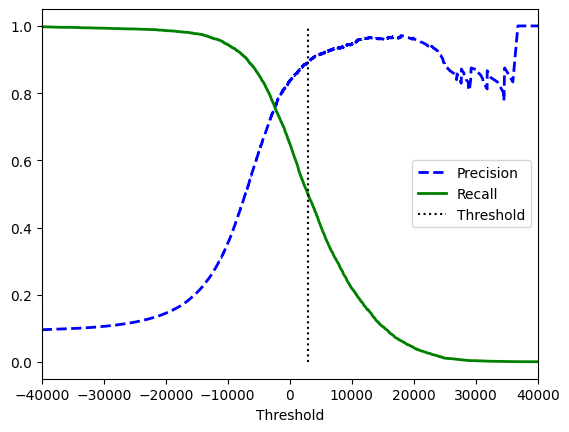

In [25]:
#use matplotlib to plot precision and recall as functions of the threshold value
plt.plot(thresholds, precisions[:-1], "b--", label = "Precision", linewidth = 2) #exclude last result for precision as this is results from threshold of infinity
plt.plot(thresholds, recalls[:-1],"g-", label = "Recall", linewidth = 2) #similar for recalls

#plt.vlines used to plot vertical lines from ymin to ymax
plt.vlines(threshold, 0, 1, "k", "dotted", label="Threshold")

#use plt.xlim to set x limits
plt.xlim(-40000,40000)

#use plt.xlabel, .ylabel, and .title to create labels for axes and titles
plt.xlabel("Threshold")
plt.legend()

At this threshold value, precision is near 90% and recall is around 50%. 
You can also plot precision directly against recall:

Text(0, 0.5, 'Precision')

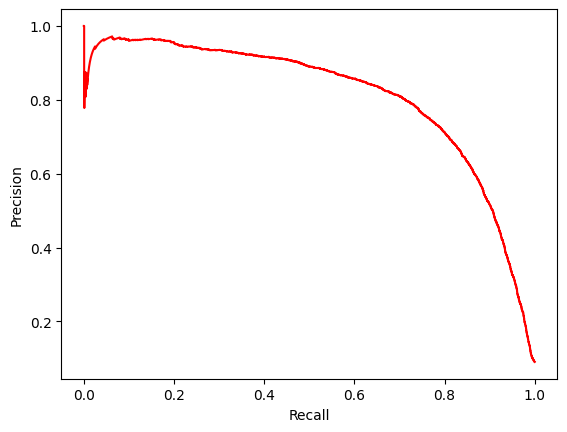

In [26]:
plt.plot(recalls[:-1], precisions[:-1], "r")
plt.xlabel("Recall")
plt.ylabel("Precision")

Precision appears to fall sharply at about 80% recall. So wise to select a precision/recall trade-off before that drop, e.g. at around 60% recall.
Good classifiers have PR curves that travel closer to the top-right corner.

### Predicting using custom threshold values 

**Obtaining threshold values**

You can search for the lowest threshold value that gives you a certain precision using NumPy's argmax method. This returns the first index of the maximum value (the 'True' value).

In [27]:
id_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[id_for_90_precision]
threshold_for_90_precision #lowest threshold to get 90% precision

3370.0194991439557

In [28]:
#To predict using this value, instead of using the predict() method, compare with the threshold value.

y_train_threshold_preds = (y_decision_scores >= threshold_for_90_precision)

In [29]:
#what are the precision and recall values?
print("Precision score is:", precision_score(y_train_5, y_train_threshold_preds))
print("Recall score is:", recall_score(y_train_5, y_train_threshold_preds))
#here we have finally obtained a high precision at a lowish recall.

Precision score is: 0.9000345901072293
Recall score is: 0.4799852425751706


### ROC Curves 

In [30]:
#to plot the ROC curve, use the roc_curve() function to compute the TPR and FPR for various threshold values.
fpr, tpr, thresholds = roc_curve(y_train_5, y_decision_scores)

<function matplotlib.pyplot.legend(*args, **kwargs)>

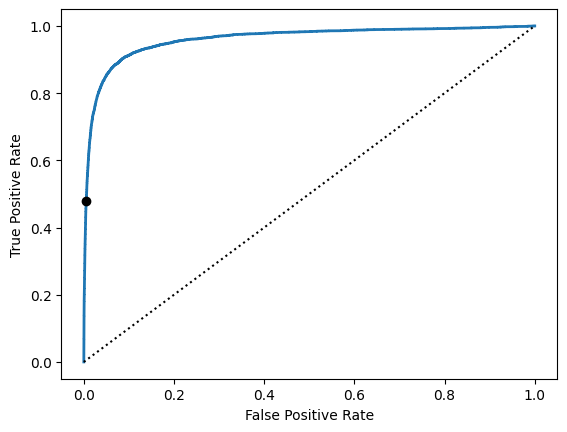

In [31]:
#find the point that corresponds to 90% precision
id_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[id_for_threshold_at_90], fpr[id_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth = 2, label = "ROC Curve") #plot the curve
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0,1],[0,1],'k:', label = "Random classifier's ROC curve") #random classifier roc curve. 'k:' format string means points are black dots
plt.plot(fpr_90, tpr_90, "ko", label = "Threshold for 90% prediction")
plt.legend

#higher threshold means less false positives (move left on curve)
#note the tradeoff between higher recall (tpr) and false positive rate

In [32]:
#obtain the ROC AUC score
roc_auc_score(y_train_5, y_decision_scores)
#is this a good score?

0.9604938554008616

### Comparing the SGD Classifier to a Random Forest Classifier

In [33]:
forest_clf = RandomForestClassifier(random_state = 42)
#random forest classifier has no decision score function, so the output probabilities are used instead

#fitting the random forest is done in the cross val predict function
y_prob_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method = "predict_proba")

In [34]:
#the estimated probability of being in each class is listed as an array for each instance
y_prob_forest[:2] #first 2 instances

array([[0.11, 0.89],
       [0.99, 0.01]])

In [37]:
#now we can use these probabilities to obtain the predictions based on the random forest
y_scores_forest = y_prob_forest[:,1] #second column, column index 1, contains the probability that it is a 5

#obtain precisions, recalls and thresholds
precisions_forests, recalls_forests, thresholds_forests = precision_recall_curve(y_train_5, y_scores_forest) #function takes in probabilities of positive class or decision scores

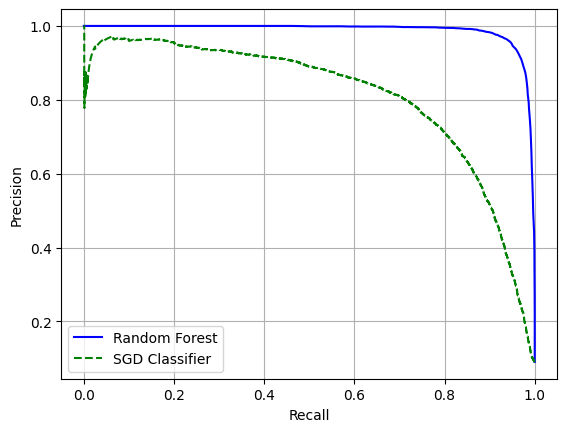

In [43]:
plt.plot(recalls_forests, precisions_forests, "b-", label = "Random Forest") #label applies to the line and will appear in legend
plt.plot(recalls, precisions, "g--", label = "SGD Classifier")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.legend(loc = "lower left") #loc keyword allows you to position the label

#random forest classifier much closer to top right, is way better

In [46]:
#how does the random forest classifier compare in terms of F1 score and ROC AUC score?

y_train_forest_preds = (y_scores_forest > 0.5) #true if estimated to have greater than 50% chance of being a 5. different results if including probabilities equal to 50%

forest_f1_score = f1_score(y_train_5, y_train_forest_preds)
print("The F1 score is ", forest_f1_score)

forest_roc_auc_score = roc_auc_score(y_train_5, y_scores_forest)
print("The forest ROC AUC score is ", forest_roc_auc_score)

forest_precision_score = precision_score(y_train_5, y_train_forest_preds)
print("The forest precision score is ", forest_precision_score)

forest_recall_score = recall_score(y_train_5, y_train_forest_preds)
print("The forest recall score is ", forest_recall_score)


The F1 score is  0.9242275142688446
The forest ROC AUC score is  0.9983436731328145
The forest precision score is  0.9905083315756169
The forest recall score is  0.8662608374838591
